# Hello, my name is Eddie Lam.
Today, today we will use an unsupervised learning technique called -- Principal Component Analysis (PCA) to explore a dataset provided by airbnb.com. 
<br>
Below are some context about the dataset.

**Context**
Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.

**Content**
This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.

**Acknowledgements**
This public dataset is part of Airbnb, and the original source can be found on this [website](http://insideairbnb.com/).

In [5]:
airbnb = read.csv("../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

# Let's check out the size of the data

In [9]:
dim(airbnb)

[1] 48895    16

As we can see, we have over 48 thousands rows of data and 16 variables.

# Let's first generate some summary statistics to get a sense of what kind of data we are working with.

In [8]:
summary(airbnb)

       id                                         name      
 Min.   :    2539   Hillside Hotel                  :   18  
 1st Qu.: 9471945   Home away from home             :   17  
 Median :19677284                                   :   16  
 Mean   :19017143   New york Multi-unit building    :   16  
 3rd Qu.:29152178   Brooklyn Apartment              :   12  
 Max.   :36487245   Loft Suite @ The Box House Hotel:   11  
                    (Other)                         :48805  
    host_id                 host_name        neighbourhood_group
 Min.   :     2438   Michael     :  417   Bronx        : 1091   
 1st Qu.:  7822033   David       :  403   Brooklyn     :20104   
 Median : 30793816   Sonder (NYC):  327   Manhattan    :21661   
 Mean   : 67620011   John        :  294   Queens       : 5666   
 3rd Qu.:107434423   Alex        :  279   Staten Island:  373   
 Max.   :274321313   Blueground  :  232                         
                     (Other)     :46943                  

# Missing Data:
From the summary statistics, we see that in column 'reviews_per_month' has 10052 rows or missing records.
But if we do another analysis, it will reveals that these missing records are not exactly missing --
these are records that simply has never been reviewed before.<br>
We can run a simple test to find out.   

In [11]:
nrow(airbnb[airbnb$number_of_reviews ==0,])

[1] 10052

As we can see from the above result, the number of records with 0 number of review is equivalent to the number of missing values.<br>
Given that's the case, we will not drop these "NA" records, but we will replace them with zero(in the reviews_per_month column). 

In [20]:
reviews_per_month_index = match('reviews_per_month',names(airbnb))
reviews_per_month_missing = is.na(airbnb$reviews_per_month)
airbnb[reviews_per_month_missing, reviews_per_month_index] = 0

In [21]:
sum(is.na(airbnb))

[1] 0

# Let's take a look at the variables we are working with.

In [22]:
names(airbnb)

[1] "id"                             "name"                          
 [3] "host_id"                        "host_name"                     
 [5] "neighbourhood_group"            "neighbourhood"                 
 [7] "latitude"                       "longitude"                     
 [9] "room_type"                      "price"                         
[11] "minimum_nights"                 "number_of_reviews"             
[13] "last_review"                    "reviews_per_month"             
[15] "calculated_host_listings_count" "availability_365"

# Dropping some of the columns
There are certain columns we simply won't need for the purpose of our -- and these columns generally have to do with record ids, columns with string data. 
Since we won't be creating heatmap in this analysis, we will also drop them. 

# Ideas for analysis:
Most people went ahead and try to predict the prices of airbnb listings. <br>
However, the airbnb listing price is actually set by the hosts. <br>
In addition, Airbnb also has a pricing recommendation system that recommends list price range for host. <br>
The purpose of recommending prices to hosts is probably to help them match their competitors(the other hosts) in the area with similar listings.<br>
Therefore, making a model to predict prices might not be the most sensible. 

On the other hand, we might want to predict the number of reviews to get a sense of the listing's popularity.<br>
However, just becasue a listing has high number of reviews doesn't mean that it's necessarily good or bad (a listing can have many bad reviews because there are many complaints).<br>

In this senario where the relationships between variables are unclear, we might want to employ some unsupervised learning technique to explore the relations between the variables. 

# One of the many unsupervised learning technique is Principal Component Analysis(PCA). 
In simple words, PCA is a technique to explores the covariance between the variables.

## In this PCA, we will try to explore what factors set the different neighborhood groups apart. 
The 5 neighborhood groups are:
1. Brooklyn
2. Manhattan
3. Queens
4. Bronx
5. Staten Island

### To prepare the data for PCA, we will first need to remove the irrelevant columns(mentioned above), and then aggregate the data by the neighborhood groups.

In [24]:
# getting the column indexes
drop = match(c('id', 'host_id', 'latitude', 'name', 'host_name',
               'neighbourhood', 'neighbourhood_group', 'longitude',
               'calculated_host_listings_count', 'last_review'), names(airbnb))
# drop columns
data = airbnb[,-c(drop)]
# !! neighborhood group excluded!!
# reappend the neighborhood group 
data = data.frame(airbnb$neighbourhood_group,data)
names(data)

[1] "airbnb.neighbourhood_group" "room_type"                 
[3] "price"                      "minimum_nights"            
[5] "number_of_reviews"          "reviews_per_month"         
[7] "availability_365"

# Before aggregating, some names in the dataframe is not numeric or logical

In [28]:
sapply(data,class)

airbnb.neighbourhood_group                  room_type 
                  "factor"                   "factor" 
                     price             minimum_nights 
                 "integer"                  "integer" 
         number_of_reviews          reviews_per_month 
                 "integer"                  "numeric" 
          availability_365 
                 "integer"

Data passed into the PCA must be numeric. Therefore, we will conver theme to numneric. 

In [32]:
convertToNumeric = c()
for(i in 2:length(names(data))){ # starting at two because first column is not the predictors
  if(class(data[,i])=='factor'){
    convertToNumeric[i] = i
  }
}
convertToNumeric = c(na.omit(convertToNumeric))
print(names(data)[convertToNumeric])

[1] "room_type"


The function correlctly gets the column we want to conver to numeric. <br>
Now we will convert room_type to numeric and aggregate the data by neighborhood_groups

In [34]:
data[,convertToNumeric] = as.numeric(data[,convertToNumeric])

neighborhood_group_data = aggregate(data[,2:7], by = list(data$airbnb.neighbourhood_group), FUN=mean)
names(neighborhood_group_data)
rownames(neighborhood_group_data) = neighborhood_group_data$Group.1
neighborhood_group_data = neighborhood_group_data[,-1] # this removes the duplicate neighborhood column that is located in the first col
neighborhood_group_data

[1] "Group.1"           "room_type"         "price"            
[4] "minimum_nights"    "number_of_reviews" "reviews_per_month"
[7] "availability_365"

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bronx,1.707608,87.49679,4.560953,26.00458,1.4756554,165.7589
Brooklyn,1.545066,124.38321,6.056556,24.20285,1.0497901,100.2323
Manhattan,1.412816,196.87581,8.579151,20.98560,0.9767822,111.9794
Queens,1.665019,99.51765,5.181433,27.70032,1.5670755,144.4518
Staten Island,1.552279,114.81233,4.831099,30.94102,1.5763807,199.6783


# Now that the data is ready, we can perform  the PCA.

Standard deviations (1, .., p=5):
[1] 2.203320e+00 9.341233e-01 4.281768e-01 2.990951e-01 8.305525e-16

Rotation (n x k) = (6 x 5):
                         PC1        PC2        PC3         PC4         PC5
room_type         -0.3825341 -0.5394426  0.4387288 -0.06702756  0.58869671
price              0.4179251  0.4000599  0.2424849 -0.13580446  0.27367942
minimum_nights     0.4402473  0.1754175  0.3294808 -0.37134101  0.31320348
number_of_reviews -0.4056322  0.3863305 -0.5765686 -0.33520640  0.49011261
reviews_per_month -0.4319132  0.1923823  0.3837545 -0.62621851 -0.48032647
availability_365  -0.3661996  0.5761251  0.4005766  0.57849577  0.09754721

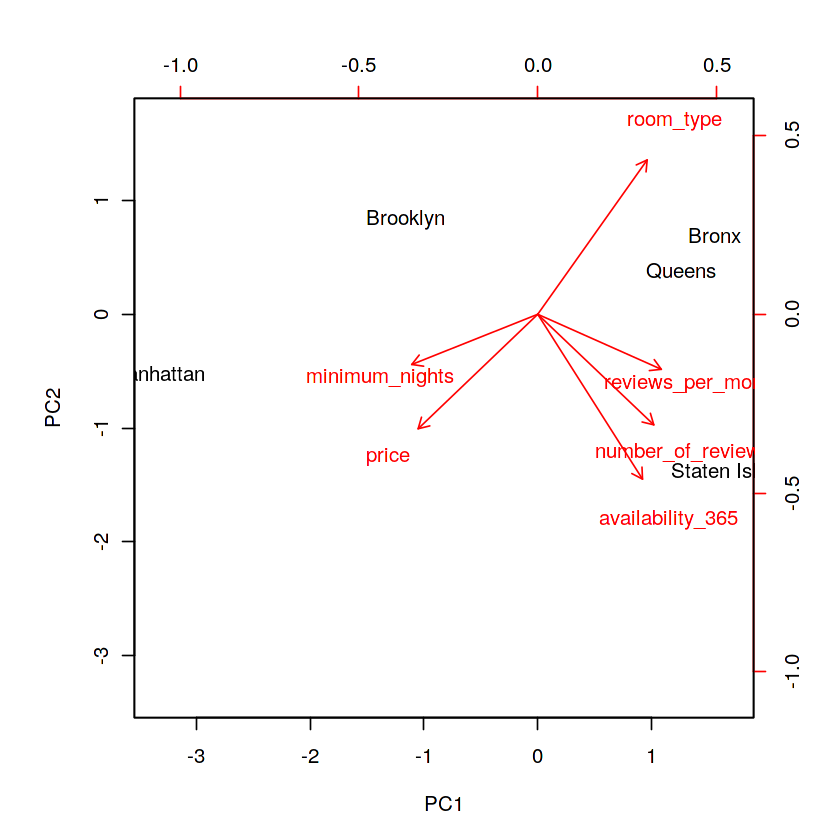

In [36]:
# perform pricipal component analysis
pr.out = prcomp(neighborhood_group_data,scale = TRUE)
pr.out
par(mfrow=c(1,1))
# biplot(pr.out, scale = 0)
pr.out$rotation = -pr.out$rotation
pr.out$x = -pr.out$x
biplot(pr.out,scale = 0)

## Screeplot
(some basic info reading the screeplot: the arrows/variables that point to the same direction together indicates having linear associations)

Looking at the screeplot, if we look at the horizontal axis, for principal component 1, which places a heavier emphasis on all the variables except room type to distinghuish the 5 neighborhood group, we can see 2 groupings already, with Brookly and Manhattan grouped together; and Bronx, Queens, and Staten Island in the other group. 

Then, if we look at the vertical axis, the second principal component combination which places a heavier emphasis on room_type than all other variables, it further divides up the neighborhood group. For example, though Brooklyn and Manhattan are similar on the other dimensions/attributes, they are quite different from each other based on typical listing room type. 

---

### PCA Diagnostics:

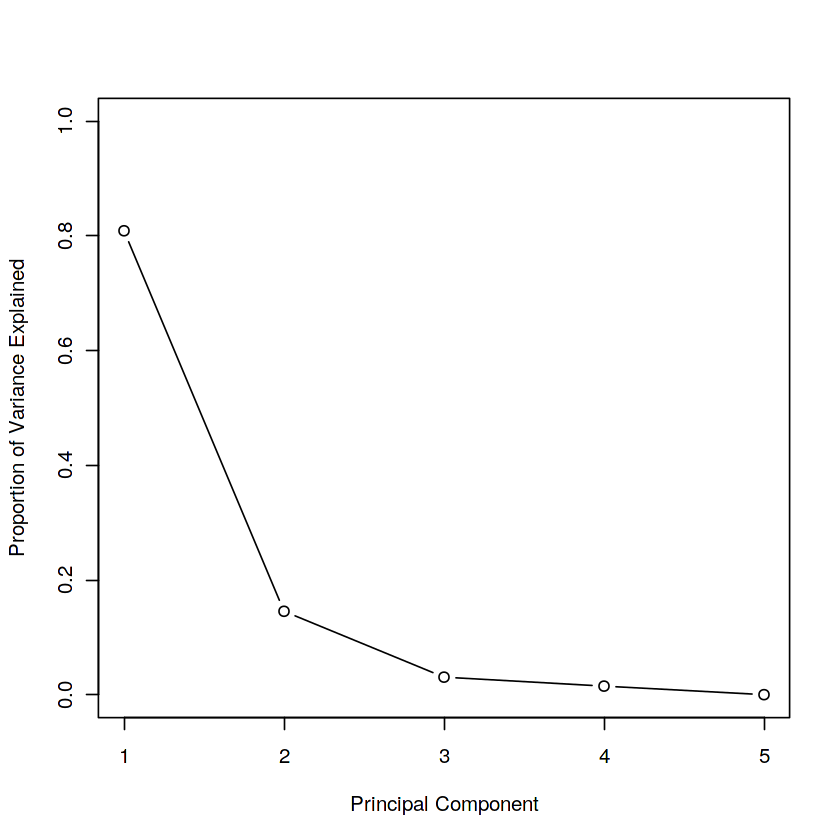

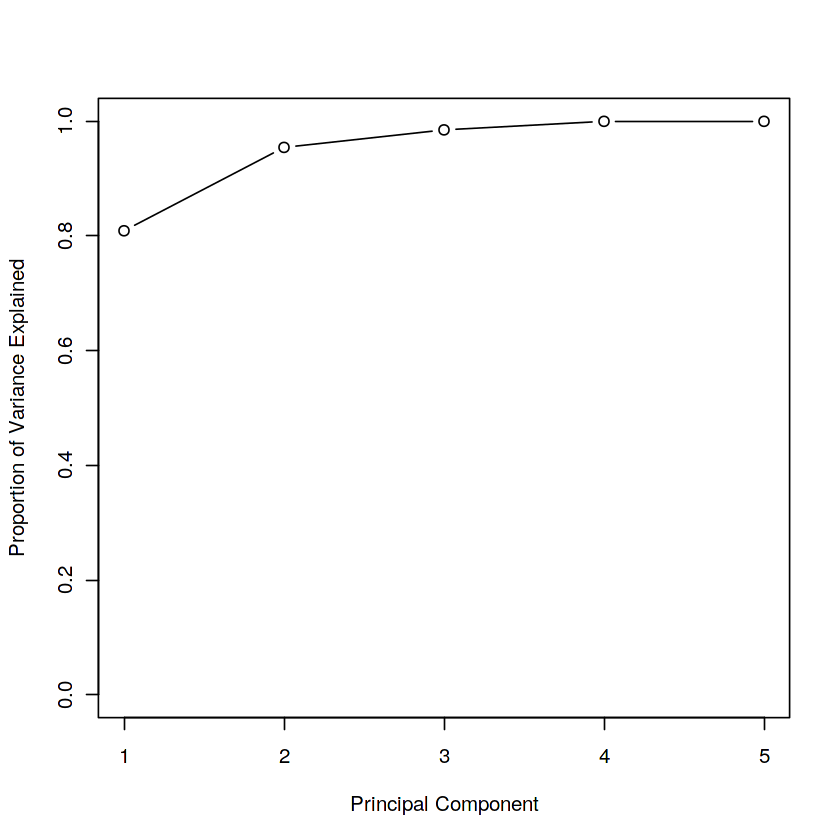

In [40]:
# checking the variances
pr.var = pr.out$sdev^2
pve = pr.var/sum(pr.var)
# variance explained %
# pve

par(mfrow=c(1,1))

plot(pve, xlab = "Principal Component", ylab = "Proportion of Variance Explained", 
     ylim = c(0,1), type = "b")
plot(cumsum(pve), xlab = "Principal Component", ylab = "Proportion of Variance Explained", 
     ylim = c(0,1), type = "b")


## Diagnostic Plots:
The two diagnostic plots essentially look at the amount of variances explained by the pricipal components.<br>
From both of the diagnostic plots, we see that the majority of the variances are explained by the first two principal components.<br>
Therefore, it affirms us that the screeplot is a significant way to visualize the result. 

# Conclusion:
Unsupervised learning techniques are often used to explore the relationships between the variables when there's no clear dependency between the variables.<br> Therefore, unsupervised learning technique like PCA are often used for exploring relationships to generate hypotheses about the variables for further predictive analysis.<br> For example, a supervised learning technique might give us some inspirations to engineer our own features to make predictions.<br>
<br>
### Anyway...
I hope you find this notebook helpful.<br>
(I am learning PCA as I build the model as well. If there are some concepts that I didn't explained correctly, please point it out!)

### Thank You! 

Notebook author: (Eddie) Chiu-Ming Lam